In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import sys
sys.path.append('../../python/')
from general_functions import load_5D_PDF_from_file
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import tables
import glob

def plot_2d_hist(hist,xedges,yedges,
                xlim,ylim,
                xlabel='',ylabel='',title='',cmap='coolwarm',
                vmin=1e-5,vmax=1e-1,same_plot=False,alpha=1.0):

    hist=hist.T
    hist=np.ma.masked_where(hist==0,hist)
    #label='nentries: %i'%np.sum(hist)

    if not same_plot:
        plt.figure()#dpi=320)
    plt.pcolormesh(xedges,yedges,hist,alpha=alpha,
                   cmap=cmap,norm=LogNorm(vmin=vmin,vmax=vmax))
    #cbar=plt.colorbar()
    #plt.scatter([2.0],[2],color=None,s=0,label=label)
    #plt.legend()
    plt.xlim(xlim)
    plt.ylim(ylim)
    #plt.xlabel(xlabel)
    #plt.ylabel(ylabel)
    #plt.title(title)
    return plt

def plot_3dhist(bkg_hist,bincenters,azim,elev,outputname,vmin,vmax):
    Q,T,R = np.meshgrid(bincenters[1],bincenters[0],bincenters[2])
    c= bkg_hist/np.sum(bkg_hist)

    Q=Q.T
    T=T.T
    R=R.T
    c=c.T
    #print np.shape(Q.T), np.shape(T.T), np.shape(R.T), np.shape(bkg_hist.T)

    reshape_ = np.prod(np.shape(Q))
    Q = Q.reshape(reshape_)
    T = T.reshape(reshape_)
    R = R.reshape(reshape_)
    c= c.reshape(reshape_)

    select=(c!=0)#&(np.random.rand(len(c))>0.5)
    Q=Q[select]
    T=T[select]
    R=R[select]
    c=np.log10(c[select])
    alpha=np.ones_like(c)
    alpha[c<-2]=0.70
    alpha[c<-3]=0.60
    alpha[c<-4]=0.50
    alpha[c<-5]=0.40
    alpha[c<-6]=0.30

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.jet
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    c= m.to_rgba(c)
    c.T[3]=alpha

    fig=plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(R,T,Q,zdir='Q',c=c,s=30,edgecolors=c)
    ax.azim = azim
    ax.elev = elev

    ax.set_xlabel('R')
    ax.set_ylabel('Q')
    ax.set_zlabel('T')
    
    ax.set_xlim([0,3.5])
    ax.set_ylim([-3.2,4])
    ax.set_zlim([-5.2,4.2])
    #fig.colorbar(myax)
    
    fig.savefig(outputname,bbox_inches='tight')
    
    plt.close()
    
    return

def hist_2d_proj(hist3d,axis=0):
    if axis==0:
        axes=[0,1,2]
    if axis==1:
        axes=[1,0,2]
    if axis==2:
        axes=[2,0,1]
    
    hist3d=np.transpose(hist3d,axes=axes)
    
    proj_hist=np.zeros_like(hist3d[0])
    print np.shape(proj_hist)
    for i in range(len(hist3d)):
        proj_hist += hist3d[i]
    
    return proj_hist

def hist_1d_proj(hist2d,axis=0):
    if axis==0:
        axes=[0,1]
    if axis==1:
        axes=[1,0]
        
    hist2d=np.transpose(hist2d,axes=axes)
    
    proj_hist=np.zeros_like(hist2d[0])
    print np.shape(proj_hist)
    for i in range(len(hist2d)):
        proj_hist += hist2d[i]
    
    return proj_hist

def plot_2D_projected_hist(hist3d,edges,axis=0,
                           xlabel='',ylabel='',
                           event_overlay=False, event=None):
    projected_hist = hist_2d_proj(hist3d,axis)
    if axis==0:
        xedges= edges[1]
        yedges= edges[2]
    if axis==1:
        xedges= edges[0]
        yedges= edges[2]
    if axis==2:
        xedges= edges[0]
        yedges= edges[1]
        
    xlim = [xedges[0]-0.25,xedges[-1]+0.25]
    ylim = [yedges[0]-0.25,yedges[-1]+0.25]
    
    projected_hist /=np.sum(projected_hist)
    
    projected_hist = projected_hist.T
    
    plot_2d_hist(projected_hist,yedges,xedges,ylim,xlim,xlabel,ylabel,cmap='jet')
    
    if event_overlay:
        xcenters=(xedges[:-1]+xedges[1:])/2.0
        ycenters=(yedges[:-1]+yedges[1:])/2.0

        xscatter=[]
        yscatter=[]
        zscatter=[]
        for r,row in enumerate(hist_2d_proj(event,axis)):
            for c,element in enumerate(row):
                if element!=0:
                    xscatter.append(xcenters[r])
                    yscatter.append(ycenters[c])
                    zscatter.append(element)
        xscatter=np.array(xscatter)
        yscatter=np.array(yscatter)
        zscatter=np.array(zscatter)
        
        plt.scatter(yscatter,xscatter,marker='s',s=10*zscatter,edgecolor='k',facecolor='r',
                    alpha=0.6)
    
    return

In [3]:
sig_pdf_file='../../files/PDF_12360_0123x.hd5'
bkg_pdf_file='../../files/PDF_12362_0123x.hd5'
temp=load_5D_PDF_from_file(SigPDFFileName=sig_pdf_file, BkgPDFFileName=bkg_pdf_file)
sig_hist=temp[0]
bkg_hist=temp[1]
binedges=temp[2]
distinct_regions_binedges=temp[3]
labels=temp[4]
sig_n_events=temp[5]
bkg_n_events = temp[6]

In [4]:
# find the logE and coszen bins select those bins in sig/bkg pdfs
logEbincenters = np.array((binedges[0][1:] + binedges[0][:-1] )/2.)
coszenbincenters = np.array((binedges[1][1:] + binedges[1][:-1] )/2.)

logE=-0.01
dE = np.absolute(logEbincenters - logE)
Ebin=np.where(np.amin(dE)==dE)[0][0]

coszen=0.96
dcZ = np.absolute(coszenbincenters - coszen)
cZbin = np.where(np.amin(dcZ)==dcZ)[0][0]

sig_hist_3dslice = sig_hist[Ebin][cZbin]
bkg_hist_3dslice = bkg_hist[Ebin][cZbin]

binedges_3dslice = binedges[2:]

(70, 50)


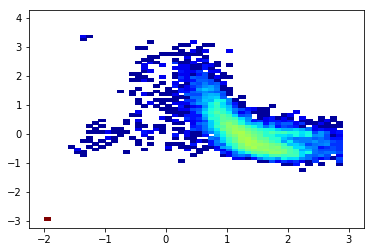

In [7]:
plot_2D_projected_hist(sig_hist_3dslice,binedges_3dslice,axis=2)

In [27]:
sig_hdf_files=glob.glob('../../files/Events_12360_?x.hd5.hd5')
bkg_hdf_files=glob.glob('../../files/Events_12362_?x.hd5.hd5')

In [30]:
def load_hdf_file(tfiles):
    d={}
    for tfile in tfiles:
        f=tables.open_file(tfile)
        for name in f.root.IceTopLLHR.colnames:
            if tfile==tfiles[0]:
                d[name]= eval('f.root.IceTopLLHR.cols.'+name+'[:]')
            else:
                d[name]=np.concatenate( (d[name],eval('f.root.IceTopLLHR.cols.'+name+'[:]')) )
        if tfile==tfiles[0]:
            d['log_s125']=np.log10(f.root.LaputopParams.cols.s125[:])
            d['cos_zen']=np.cos(f.root.Laputop.cols.zenith[:])
        else:
            d['log_s125']=np.concatenate( (d['log_s125'],np.log10(f.root.LaputopParams.cols.s125[:])) )
            d['cos_zen']=np.concatenate( (d['cos_zen'], np.cos(f.root.Laputop.cols.zenith[:])) )
    return d

In [31]:
llhr={}
llhr['sig']=load_hdf_file(sig_hdf_files)
llhr['bkg']=load_hdf_file(bkg_hdf_files)

25408
208
29522
176


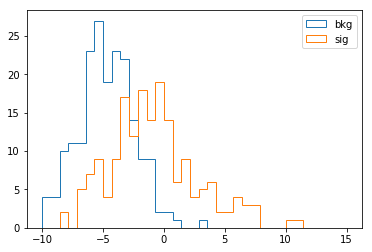

In [45]:
low_E=1.5
high_E=1.6
low_z=0.8
high_z=.85
for key in llhr.keys():
    cut1=llhr[key]['isGood']==1.0
    cut2=llhr[key]['tanks_have_nans']==0.
    cut3=llhr[key]['log_s125']>=low_E
    cut4=llhr[key]['log_s125']<high_E
    cut5=llhr[key]['cos_zen']>=low_z
    cut6=llhr[key]['cos_zen']<high_z
    select=cut1&cut2&cut3&cut4&cut5&cut6
    print len(select)
    print len(select[select])
    hist_this ='llh_ratio'
    range=[-10,15]
    bins=35
    #hist_this='n_extrapolations_bkg_PDF'
    #range=[0,20]
    #bins=20
    plt.hist(llhr[key][hist_this][select],range=range,bins=bins,label=key,histtype='step')
plt.legend()

In [34]:
llhr['sig'].keys()

['cos_zen',
 'n_extrapolations_sig_PDF',
 'Run',
 'exists',
 'isGood',
 'n_extrapolations_bkg_PDF',
 'llh_bkg',
 'llh_ratio',
 'log_s125',
 'SubEvent',
 'SubEventStream',
 'llh_sig',
 'tanks_have_nans',
 'Event']

In [2]:
def load_results_hist(tfile):
    f=tables.open_file(tfile)
    labels=f.root.labels[:]
    nevents=f.root.n_events[:]
    edges0=f.root.binedges_0[:]
    edges1=f.root.binedges_1[:]
    edges2=f.root.binedges_2[:]
    hist=f.root.hist[:]
    f.close()
    return hist, [edges0,edges1,edges2], nevents,labels

In [3]:
sig_hist, edges, sig_nevents, labels = load_results_hist('../../files/results_sig_Ezenllhr.hd5')
bkg_hist, edges, bkg_nevents, labels = load_results_hist('../../files/results_bkg_Ezenllhr.hd5')

In [4]:
sig_onedhist=hist_2d_proj(sig_hist,axis=1)[3]
bkg_onedhist=hist_2d_proj(bkg_hist,axis=1)[3]

(12, 3500)
(12, 3500)


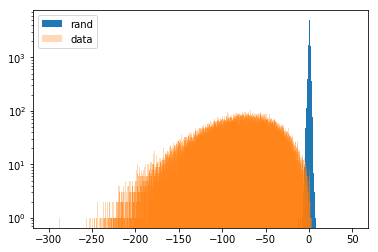

In [5]:
plt.bar(edges[2][:-1],sig_onedhist,alpha=1.,label='rand')
plt.bar(edges[2][:-1],bkg_onedhist,alpha=0.3,label='data')
plt.yscale('log')
#plt.xlim([-1,1])
plt.legend()

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])